# Network Analysis Project

## Assignment Description

You will have to deliver your project at the end of the course (deadline to be determined). You have to hand in a presentation (in PDF or Power Point format). It is mandatory to include the following information:

- Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).
- Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).
- A clear statement of your research question, the result of project phase #3.
- The analysis, results, and interpretation that allow you to answer your research question, the result of project phase #4.
You're free to include this in the order you prefer and to add any additional information you deem necessary, but these are the mandatory components.

The format of the oral is as follows: the students mAlaskae a joint presentation followed by group questions. Subsequently the students are having individual examination with additional questions while the rest of the group is outside the room. The length of the oral will be 15 minutes X number of group members plus one -- for instance, a group of 6 will have 105 minutes ((6+1)*15). Which means you have 15 minutes of group exam plus 15 minutes of individual exam each.

## Environment Setup

This project uses Python libraries that are essential for the performed analysis. MAlaskae sure to have the dependencies listed in requirements.txt installed locally using the Python Package Manager pip.

In [1]:
# %%capture
# %pip install -r requirements.txt

### Packages

In [2]:
# network representation and algorithms
import networkx as nx
from networkx.algorithms import bipartite
from pyvis.network import Network
from networkx import linalg as nxla
import powerlaw as pl                                            # powerlaw fits for degree distribution
from IPython.display import display, Image, Markdown             # display images and markdown in jupyter

# general data science libraries
from matplotlib import pyplot as plt                            # basic plotting
import seaborn as sns                                           # advanced plotting
import numpy as np                                              # for representing n-dimensional arrays
import scipy as sp                                              # numerical computation
import pandas as pd                                             # dataframes

# python standard library
from time import time                                           # used for timing execution
from datetime import date, datetime                             # get current data and time
import json                                                     # read/ write json
import re                                                       # regex search 
import os                                                       # os operations
import random                                                   # randomness
from collections import Counter                                 # efficient counting
import contextlib

# custom imports
from cscripts import metrics
from cscripts import plotting
from cscripts import summarise
from cscripts import backboning # michele
#from cscripts import github_api
from cscripts import projections

c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Set global style of plots

Below you can specify global style for all plots or any other setups related to plots visualization.

In [3]:
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})

### Flags

Flags are used to control the run flow of the notebook when executed at once. This is useful, to prevent operations that should only produce a result once, from running multiple times.

In [33]:
# section flags
LOAD_DATA = True # Loads raw data for initial inspection
TRANSFORM_DATA = True # Transforms raw data into more suitable format (Load data needs to be on as well)
COMPUTE_PROJECTIONS = True
GENERATE_SUMMARY_PROJ = True # Summary related to projections only
GET_WEIGHT_EDGE_DiSTR = False # Do you want to get the weight distribution of the edges?
GET_ONE_CC = True # Do you want to get one connected component for each projection?
DO_BACKBONING = True
GENERATE_SUMMARY_PROJ_BACKB = True # Summary related to projected AND backboned graph
SAVE_FIG = True # Do you want to save all generated figures?
RANDOM_SAMPLE = True

### Constants

In [5]:
PATH_TO = {}
PATH_TO['data'] = {}
PATH_TO['data']['raw'] = 'data/raw'
PATH_TO['data']['transformed'] = 'data/transformed'
PATH_TO['data']['projections'] = 'data/projections'
PATH_TO['data']['backboning'] = 'data/backboning'
PATH_TO['data']['figures'] = 'data/figures'
PATH_TO['data']['summaries'] = 'data/graph_summaries'

### Folder Structure

Create relevant folders to read from and write to, if not yet existent.

In [6]:
# iterate over path_to dict
for path in PATH_TO['data'].values():
    os.makedirs(path) if not os.path.exists(path) else print('Already exists.')

Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.


#### #1 Data Importing and Cleaning

In [7]:
if LOAD_DATA:
    u_data = pd.read_csv(f"{PATH_TO['data']['raw']}/u.data", sep='\t', names=['user_id', 'item_id', 'rating'])
    u_genre = pd.read_csv(f"{PATH_TO['data']['raw']}/u.genre", sep='|', names=['genre', 'genre_id'])
    u_item = pd.read_csv(f"{PATH_TO['data']['raw']}/u.item", sep='|', encoding='latin-1', 
                        names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
                                'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
    u_user = pd.read_csv(f"{PATH_TO['data']['raw']}/u.user", sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
    u_occupation = pd.read_csv(f"{PATH_TO['data']['raw']}/u.occupation", names=['occupation'])
    
# Check for missing values
missing_values = {
    'u_data': u_data.isnull().sum(),
    'u_genre': u_genre.isnull().sum(),
    'u_item': u_item.isnull().sum(),
    'u_user': u_user.isnull().sum(),
    'u_occupation': u_occupation.isnull().sum(),
}

missing_values

{'u_data': user_id    0
 item_id    0
 rating     0
 dtype: int64,
 'u_genre': genre       0
 genre_id    0
 dtype: int64,
 'u_item': movie_id                 0
 movie_title              0
 release_date             1
 video_release_date    1682
 IMDb_URL                 3
 unknown                  0
 Action                   0
 Adventure                0
 Animation                0
 Children's               0
 Comedy                   0
 Crime                    0
 Documentary              0
 Drama                    0
 Fantasy                  0
 Film-Noir                0
 Horror                   0
 Musical                  0
 Mystery                  0
 Romance                  0
 Sci-Fi                   0
 Thriller                 0
 War                      0
 Western                  0
 dtype: int64,
 'u_user': user_id       0
 age           0
 gender        0
 occupation    0
 zip_code      0
 dtype: int64,
 'u_occupation': occupation    0
 dtype: int64}

The data looks clean with no missing values in the u_data, u_user, and u_occupation files. However, there are missing values in the u_item file:

- release_date: 1 missing value
- video_release_date: 1682 missing values
- IMDb_URL: 3 missing values

We will handle these missing values as follows:

- release_date: We can fill the missing value with the mode of the release_date column.
- video_release_date: Since there are too many missing values, we will drop this column.
- IMDb_URL: we will drop this column, as the IMDb URL is not critical for our analysis.

In [8]:
u_item['release_date'].fillna(u_item['release_date'].mode()[0], inplace=True)
u_item.drop('video_release_date', axis=1, inplace=True)
u_item.drop('IMDb_URL', axis=1, inplace=True)


# Verify that missing values are handled
u_item.isnull().sum()


movie_id        0
movie_title     0
release_date    0
unknown         0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64

The missing values in the u_item file have been handled, and now we have no missing values in any of the data files.

### #2 Data Aggregation

We merge the datasets to create a single dataframe that includes user demographics, movie information, and ratings. This will allow us to exploratory data analysis on the combined data.

In [9]:
import os

# Merge the datasets
data = pd.merge(u_data, u_user, on='user_id')
data = pd.merge(data, u_item, left_on='item_id', right_on='movie_id')

# Drop duplicate columns
data.drop('movie_id', axis=1, inplace=True)

# Define the path to save the TXT file
save_folder = PATH_TO['data']['transformed']
save_path = os.path.join(save_folder, 'aggregated_data.txt')
data.to_csv(save_path, sep='\t', index=False)

# Display the first few rows of the merged data
data.head()

,user_id,item_id,rating,age,gender,occupation,zip_code,movie_title,release_date,unknown,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,49,M,writer,55105,Kolya (1996),24-Jan-1997,0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,23,M,programmer,94086,Kolya (1996),24-Jan-1997,0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,42,M,executive,98101,Kolya (1996),24-Jan-1997,0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,60,M,retired,94702,Kolya (1996),24-Jan-1997,0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,31,M,marketing,75240,Kolya (1996),24-Jan-1997,0,...,0,0,0,0,0,0,0,0,0,0


### #3 Exploratory Data Analysis

#### Exploratory Statistical Analysis

The data has been successfully merged into a single dataframe that includes user demographics, movie information, and ratings. Now, we will proceed to simple statistical analysis, to understand the characteristics of the data. In this step, we will perform the following analyses:

User Demographics:
- Distribution of user ages.
- Distribution of user genders.
- Distribution of user occupations.

Movie Information:
- Distribution of movie genres.
- Distribution of movie release years.

Ratings:
- Distribution of ratings.
- Average rating per movie.
- Average rating per user.

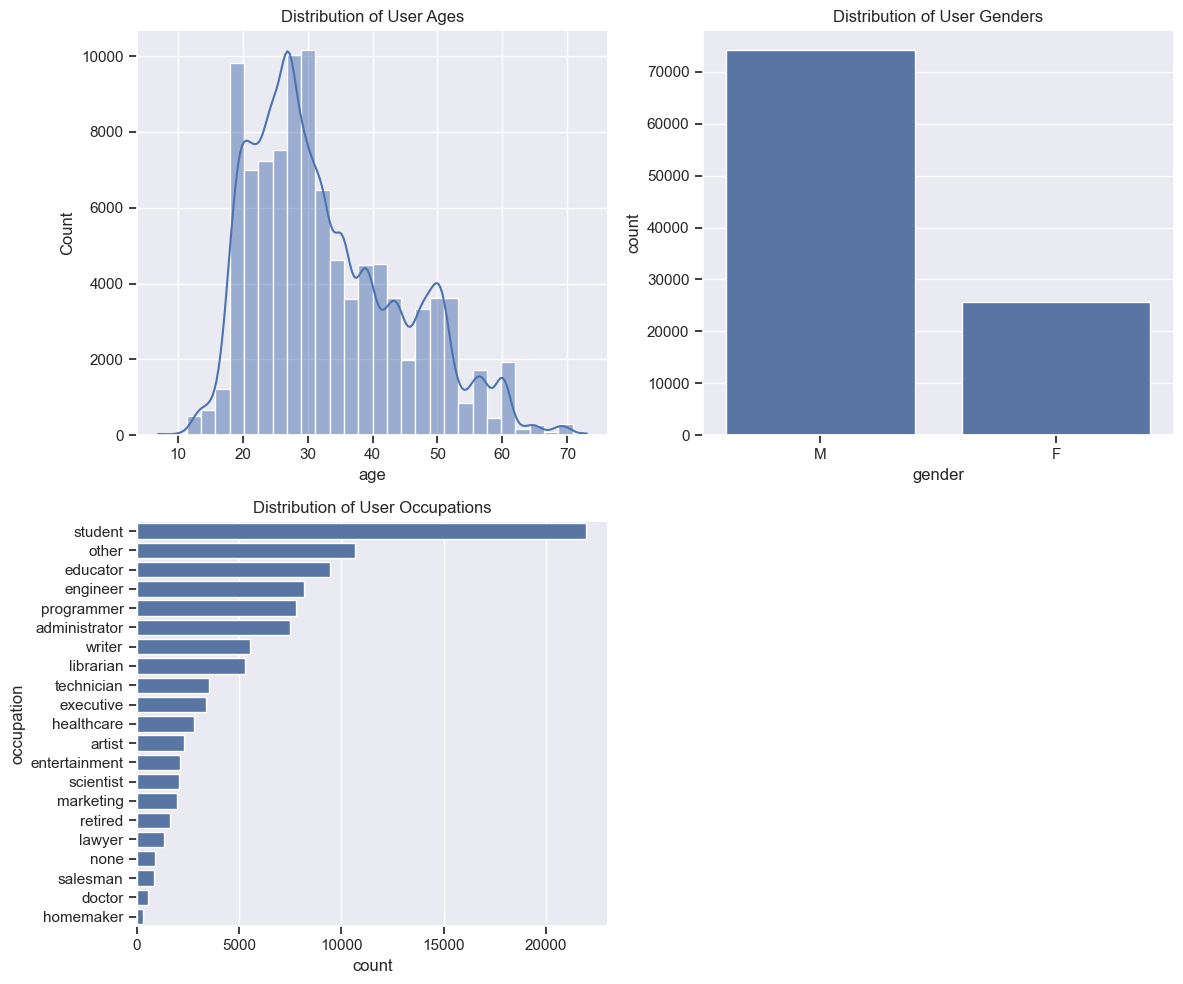

In [10]:
# User Demographics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Distribution of user ages
sns.histplot(data['age'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of User Ages')

# Distribution of user genders (countplot is fine for categorical data)
sns.countplot(data=data, x='gender', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of User Genders')

# Distribution of user occupations
sns.countplot(data=data, y='occupation', order=data['occupation'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of User Occupations')

# Add an empty plot in the bottom-right corner
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

The first set of plots provides insights into the user demographics:

- Distribution of User Ages: The age distribution is fairly spread out, with a higher concentration of users in the 20-30 age range.
- Distribution of User Genders: There are more male users than female users in the dataset.
- Distribution of User Occupations: The most common occupations are student, other, and educator.

Next, let's analyze the movie information.​​

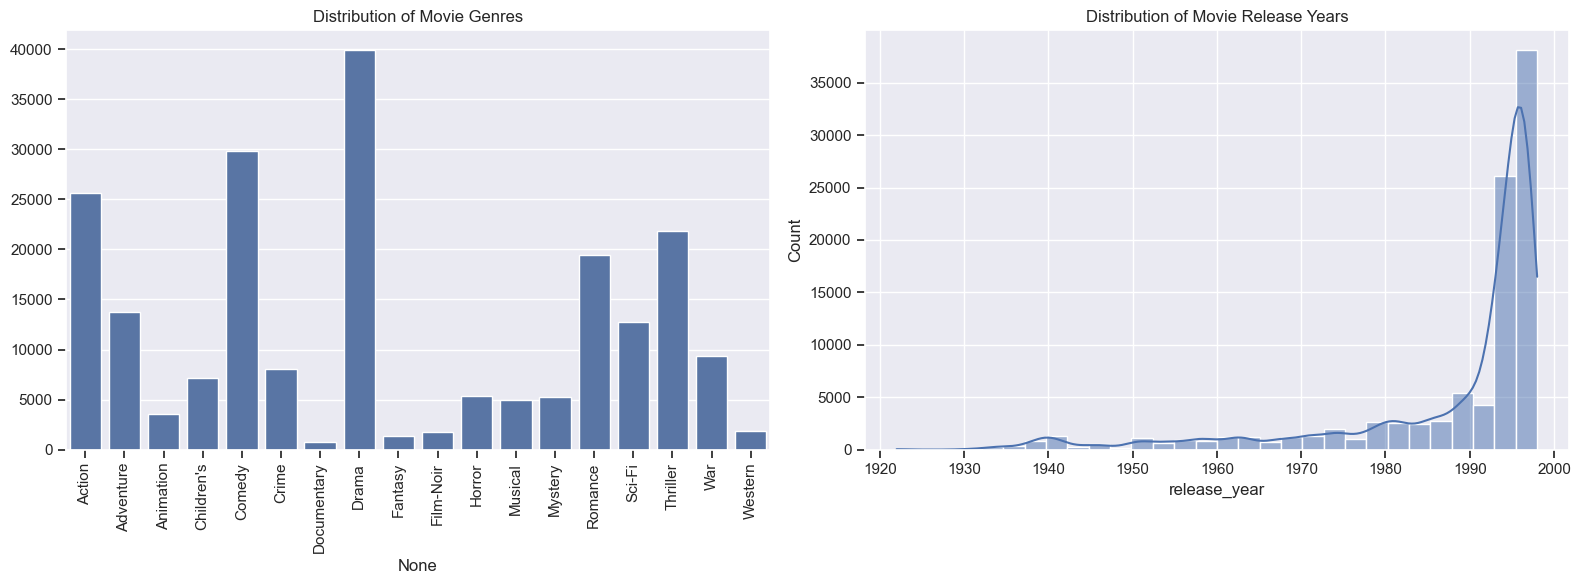

In [11]:
# Movie Information
# Convert release date to datetime format and extract year
data['release_year'] = pd.to_datetime(data['release_date'], errors='coerce').dt.year

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))  # Create a 1x2 grid

# Distribution of movie genres
genre_cols = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_counts = data[genre_cols].sum()
sns.barplot(x=genre_counts.index, y=genre_counts.values, ax=axes[0])
axes[0].set_title('Distribution of Movie Genres')
axes[0].tick_params(axis='x', rotation=90)

# Distribution of movie release years
sns.histplot(data['release_year'].dropna(), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Movie Release Years')

plt.tight_layout()
plt.show()


The second set of plots provides insights into the movie information:

- Distribution of Movie Genres: The most common genres are Drama, Comedy, and Action.
- Distribution of Movie Release Years: There is a peak in the number of movies released during the 1990s, which might be due to the dataset being collected in 1998.

Next, let's analyze the ratings.​

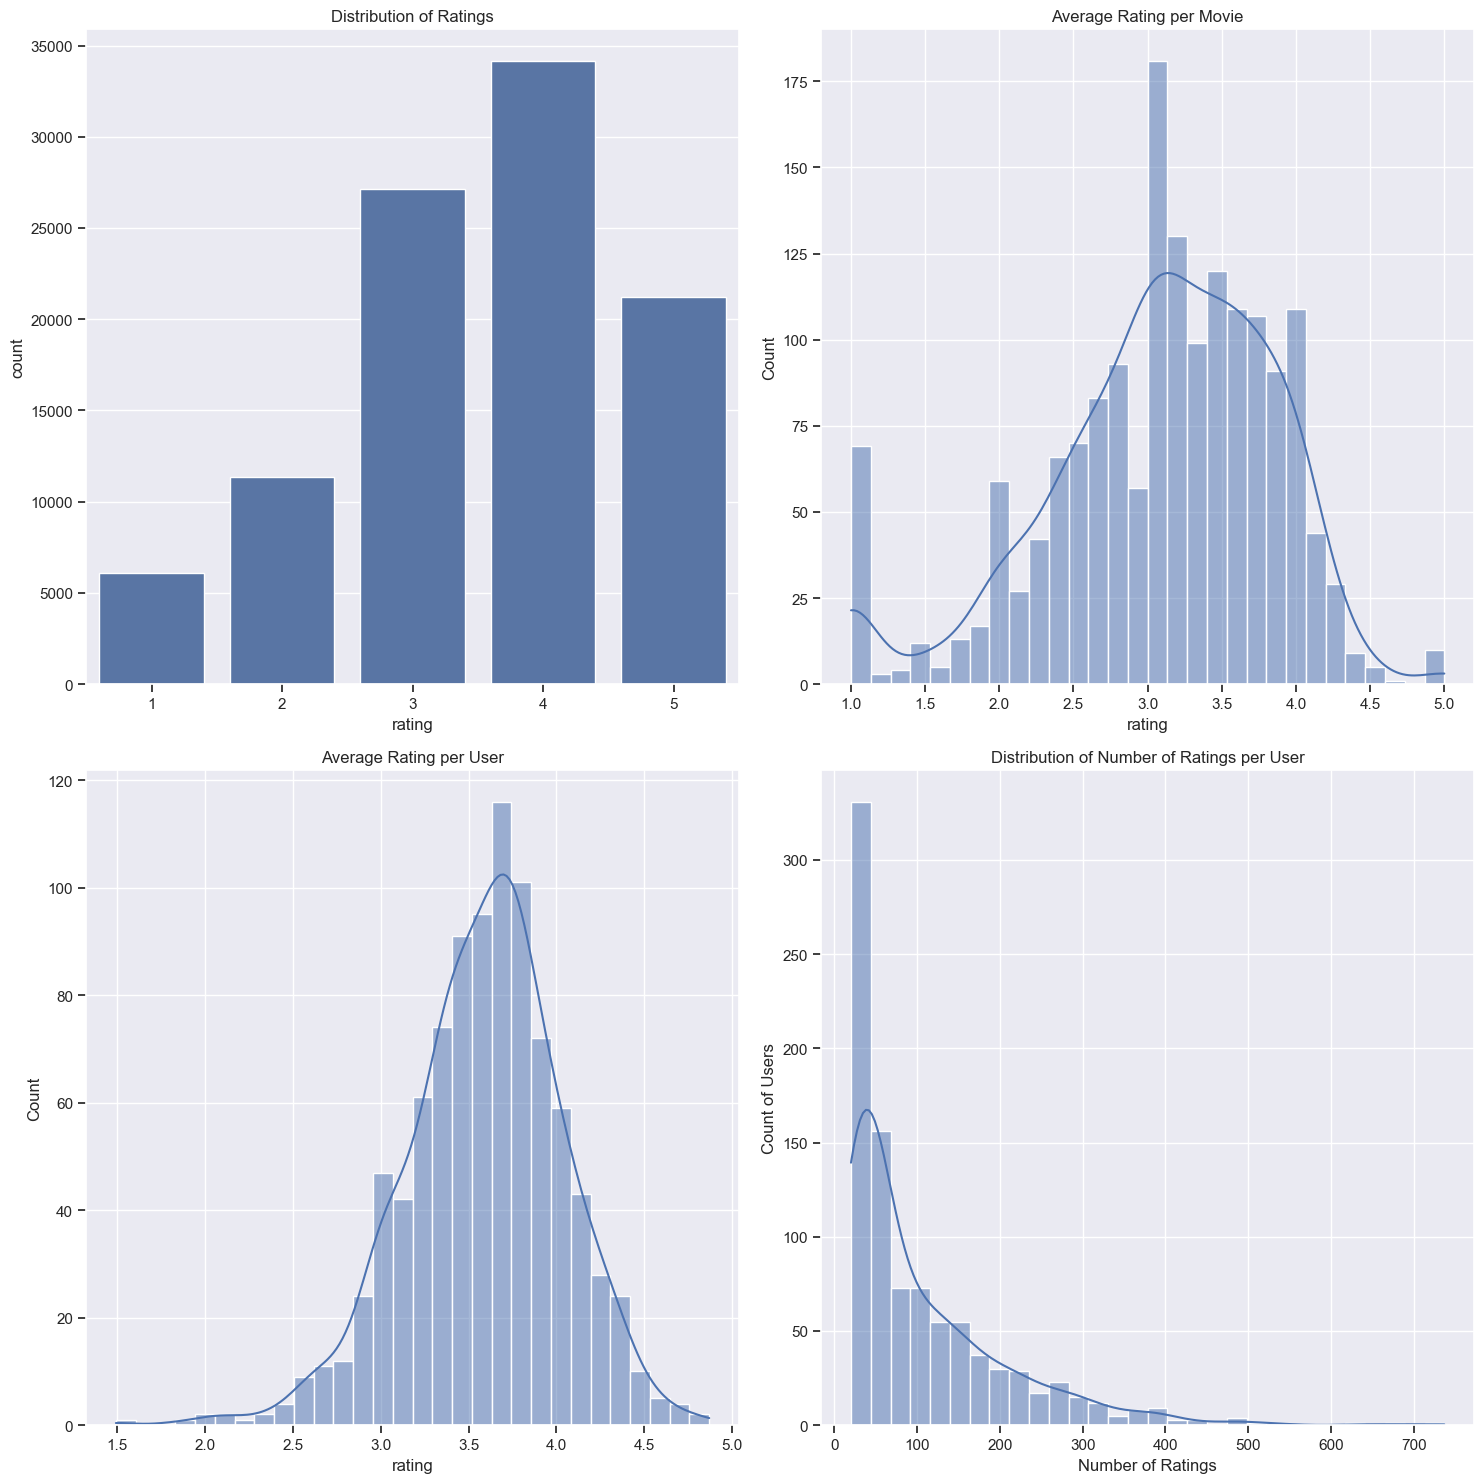

In [12]:
# Ratings
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))  # Adjusted for a 2x2 grid

# Distribution of ratings with specified order
sns.countplot(data=data, x='rating', ax=axes[0, 0], order=sorted(data['rating'].unique()))
axes[0, 0].set_title('Distribution of Ratings')

# Average rating per movie
avg_rating_per_movie = data.groupby('movie_title')['rating'].mean().sort_values(ascending=False)
sns.histplot(avg_rating_per_movie, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Average Rating per Movie')

# Average rating per user
avg_rating_per_user = data.groupby('user_id')['rating'].mean().sort_values(ascending=False)
sns.histplot(avg_rating_per_user, bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Average Rating per User')

# Count the number of ratings per user
num_ratings_per_user = data.groupby('user_id')['rating'].count()
sns.histplot(num_ratings_per_user, bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Number of Ratings per User')
axes[1, 1].set_xlabel('Number of Ratings')
axes[1, 1].set_ylabel('Count of Users')

plt.tight_layout()
plt.show()

The third set of plots provides insights into the ratings:

- Distribution of Ratings: The most common rating is 4, followed by 3 and 5. Ratings 1 and 2 are less common.
- Average Rating per Movie: The distribution of average ratings per movie is fairly normal, with a peak around 3.5 to 4.
- Average Rating per User: The distribution of average ratings per user is slightly skewed to the right, with a peak around 3.5 to 4.

Top 10 average rated movies (minimum 10 ratings received):

In [13]:
# Group by movie title and calculate the average rating and number of ratings for each movie
movie_stats = data.groupby('movie_title').agg({
    'rating': ['mean', 'count']
})

# Filter movies with at least 10 ratings
movies_with_at_least_10_ratings = movie_stats[movie_stats['rating']['count'] >= 10]

# Sort the average ratings in descending order
sorted_stats = movies_with_at_least_10_ratings['rating']['mean'].sort_values(ascending=False)

# Get the top 10 movies with the highest average ratings
top_10_movies = sorted_stats.head(10)

# Display the top 10 movies, their average ratings, and the number of ratings they received
top_10_movies_with_counts = movies_with_at_least_10_ratings.loc[top_10_movies.index]
print(top_10_movies_with_counts)

                                                      rating      
                                                        mean count
movie_title                                                       
Close Shave, A (1995)                               4.491071   112
Schindler's List (1993)                             4.466443   298
Wrong Trousers, The (1993)                          4.466102   118
Casablanca (1942)                                   4.456790   243
Wallace & Gromit: The Best of Aardman Animation...  4.447761    67
Shawshank Redemption, The (1994)                    4.445230   283
Rear Window (1954)                                  4.387560   209
Usual Suspects, The (1995)                          4.385768   267
Star Wars (1977)                                    4.358491   583
12 Angry Men (1957)                                 4.344000   125


### Data Transformation

The goal of this section is to get the following two files:
- data.txt is a textfile with the edge list containing our bipartite network of users and items (movies) and their interactions (ratings).
- user_metadata.json is a json file containing the metadata of the users.
- item_metadata.json is a json file containing the metadata of the items (movies).

In [14]:
# Save the edge list to data.txt file
if TRANSFORM_DATA:
    data_txt_path = os.path.join(PATH_TO['data']['transformed'], 'data.txt')

    # Add prefix to user and item identifiers
    u_data['user_id'] = 'u' + u_data['user_id'].astype(str)
    u_data['item_id'] = 'i' + u_data['item_id'].astype(str)

    # Save the data to data.txt file
    u_data[['user_id', 'item_id', 'rating']].to_csv(data_txt_path, sep=' ', index=False, header=False)

    u_user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

    # Add prefix to user identifiers
    u_user['user_id'] = 'u' + u_user['user_id'].astype(str)

    # Convert the user metadata to a dictionary
    user_metadata_dict = u_user.set_index('user_id').to_dict(orient='index')

    # Save the user metadata to user_metadata.json file
    user_metadata_json_path = os.path.join(PATH_TO['data']['transformed'], 'user_metadata.json')
    with open(user_metadata_json_path, 'w') as f:
        json.dump(user_metadata_dict, f)

    # Add prefix to movie identifiers
    u_item['movie_id'] = 'i' + u_item['movie_id'].astype(str)

    # Convert the item metadata to a dictionary
    item_metadata_dict = u_item.set_index('movie_id').to_dict(orient='index')

    # Save the item metadata to item_metadata.json file
    item_metadata_json_path = os.path.join(PATH_TO['data']['transformed'], 'item_metadata.json')
    with open(item_metadata_json_path, 'w') as f:
        json.dump(item_metadata_dict, f)

#### Bipartite graph loading

We have loaded the data into a NetworkX graph object, with metadata imbued into the corresponding node objects. The graph that has been created is a bipartite graph, where there are two sets of nodes (users and items) and edges exist only between nodes from different sets. The edges represent the interactions between users and items, with the edge weight being the rating given by the user to the item. In this case, the two sets of nodes are:

- User nodes, which represent individual users and have metadata such as age, gender, occupation, and zip code.
- Item nodes, which represent movies and have metadata such as movie title, release date, and genres.

In [15]:
G = nx.read_edgelist("data/transformed/data.txt", data=(('weight',int),))

# Add type attribute to nodes
for node in G.nodes:
    if node.startswith('u'):
        G.nodes[node]['type'] = 'user'
    elif node.startswith('i'):
        G.nodes[node]['type'] = 'item'

# Load user metadata
with open('data/transformed/user_metadata.json', 'r') as fp:
    user_metadata = json.load(fp)

# Add user metadata to user nodes
for user_id, vals in user_metadata.items():
    if user_id in G.nodes and G.nodes[user_id]['type'] == 'user':
        G.nodes[user_id].update(vals)

# Load item metadata
with open('data/transformed/item_metadata.json', 'r') as fp:
    item_metadata = json.load(fp)

# Add item metadata to item nodes
for item_id, vals in item_metadata.items():
    if item_id in G.nodes and G.nodes[item_id]['type'] == 'item':
        G.nodes[item_id].update(vals)

# Check if the graph is bipartite
is_bipartite = nx.is_bipartite(G)
print(f"Is the graph bipartite? {is_bipartite}")

Is the graph bipartite? True


In [16]:
# Show a random user and item node's attributes
random_user_node = random.choice([n for n, d in G.nodes(data=True) if d['type'] == 'user'])
random_user_attributes = G.nodes[random_user_node]  

random_item_node = random.choice([n for n, d in G.nodes(data=True) if d['type'] == 'item'])
random_item_attributes = G.nodes[random_item_node]  

print(f"Random User Node: {random_user_node}\nAttributes: {random_user_attributes}")
print(f"Random Item Node: {random_item_node}\nAttributes: {random_item_attributes}")

Random User Node: u228
Attributes: {'type': 'user', 'age': 21, 'gender': 'F', 'occupation': 'student', 'zip_code': '22003'}
Random Item Node: i1178
Attributes: {'type': 'item', 'movie_title': 'Major Payne (1994)', 'release_date': '01-Jan-1994', 'unknown': 0, 'Action': 0, 'Adventure': 0, 'Animation': 0, "Children's": 0, 'Comedy': 1, 'Crime': 0, 'Documentary': 0, 'Drama': 0, 'Fantasy': 0, 'Film-Noir': 0, 'Horror': 0, 'Musical': 0, 'Mystery': 0, 'Romance': 0, 'Sci-Fi': 0, 'Thriller': 0, 'War': 0, 'Western': 0}


#### Exploratory Network Analysis

Below, you can find fundamental information about our bi-partite network.

In [17]:
# Store fundamental properties within pandas DF
overview = pd.DataFrame(columns=["name", "is_bipartite", "is_directed", "is_weighted", "selfloops_#", "nodes_#", "edges_#", "density"])

# save important data to dict
G_info = dict()

# fundamental stats
G_info["name"] = "MovieLens"
G_info["number_of_users"] = len([node for node in G.nodes() if G.nodes[node]['type'] == 'user'])  # Corrected line
G_info["number_of_movies"] = len([node for node in G.nodes() if G.nodes[node]['type'] == 'item'])  # Corrected line
G_info["is_directed"] = nx.is_directed(G)
G_info["is_weighted"] = nx.is_weighted(G)
G_info["selfloops_#"] = nx.number_of_selfloops(G)
G_info["nodes_#"] = nx.number_of_nodes(G)
G_info["edges_#"] = nx.number_of_edges(G)
G_info["density"] = nx.density(G)
G_info["is_bipartite"] = bool(nx.is_bipartite(G))

# add it do the overview
overview = overview.append(G_info, ignore_index=True)
overview

C:\Users\jackh\AppData\Local\Temp\ipykernel_32572\2772811835.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overview = overview.append(G_info, ignore_index=True)


,name,is_bipartite,is_directed,is_weighted,selfloops_#,nodes_#,edges_#,density,number_of_users,number_of_movies
0,MovieLens,True,False,True,0,2625,100000,0.029036,943.0,1682.0


Now, we can proceed to analyze the structure of the network, including degree distribution, centrality measures, and community detection.

- `Degree Distribution`: Analyze the degree distribution of the graph to understand how many movies each user has rated and how many users have rated each movie.
- `Centrality Measures`: Calculate centrality measures, such as degree centrality, betweenness centrality, and closeness centrality, to identify the most important nodes in the network.
- `Community Detection`: Detect communities within the network to identify groups of users with similar movie preferences or groups of movies that are commonly rated together.

Let's start with the degree distribution analysis.​

#### Degree distribution

In [18]:
user_degree = [G.degree(n) for n in G.nodes() if G.nodes[n]['type'] == 'user']
dd_user = Counter(user_degree) #getting the number of lists that have specific valuse
dd_user = pd.DataFrame(list(dd_user.items()), columns = ("k", "count")).sort_values(by = "k")
dd_user.head()

,k,count
4,20,32
119,21,24
88,22,23
34,23,21
27,24,21


In [19]:
item_degree = [G.degree(n) for n in G.nodes() if G.nodes[n]['type'] == 'item']
dd_item = Counter(item_degree) # getting the number of lists that have specific valuse
dd_item = pd.DataFrame(list(dd_item.items()), columns = ("k", "count")).sort_values(by = "k")
dd_item.head()

,k,count
269,1,141
220,2,68
252,3,60
234,4,64
231,5,51


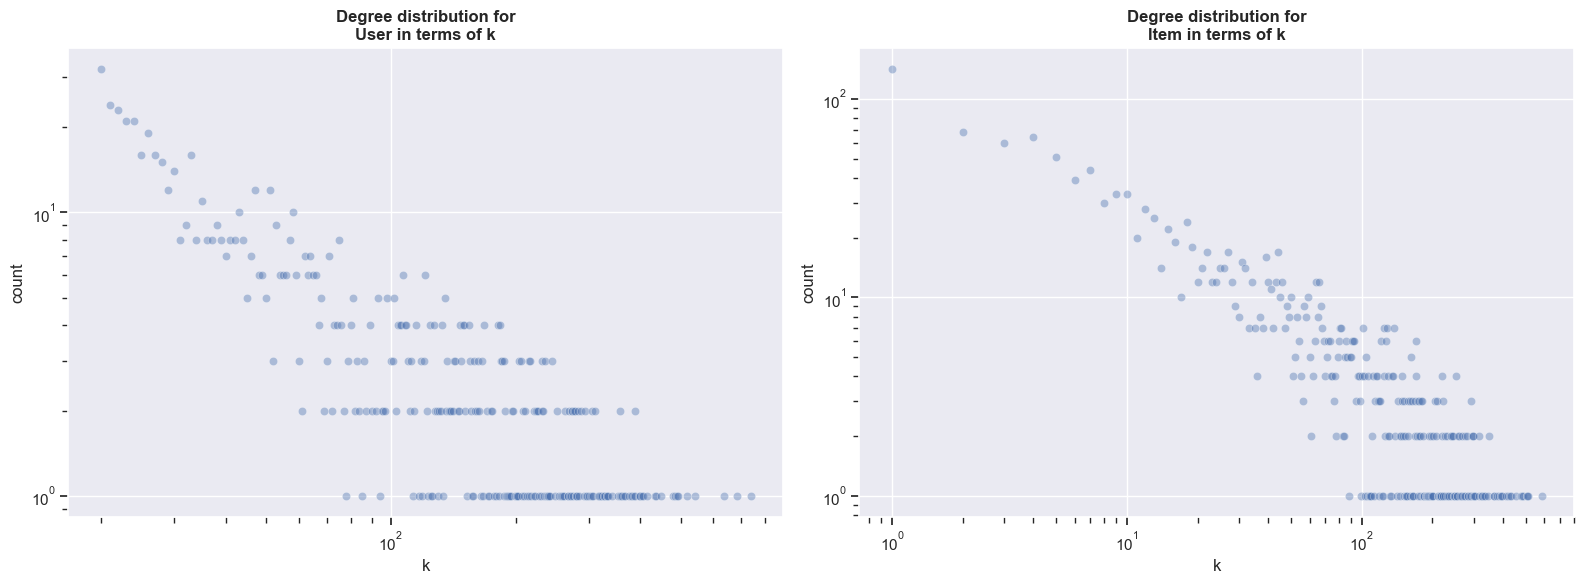

In [20]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the data
for ax, data, which_category in zip(axs, [dd_user, dd_item], ["User", "Item"]):
    sns.scatterplot(data=data, x="k", y="count", ax=ax, alpha=0.4)
    ax.set_title(f"Degree distribution for\n{which_category} in terms of k", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_count_loglog.jpg")
    
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

The scatter plots above display the degree distribution of user nodes and movie nodes on a logarithmic scale. In each plot, points represent the count of users or movies with a specific degree, which corresponds to the number of movies rated by users or the number of users who rated movies. 

These plots reveal a common pattern known as a long-tail distribution. For both users and movies, the majority have relatively low degrees, indicating that most users have rated only a few movies, and most movies have been rated by only a small number of users. However, there are outliers in each case—some users have rated a substantial number of movies, and some movies have been rated by a large number of users. This distribution highlights the presence of highly active users and highly popular movies within the dataset, while also showcasing the vast number of less active users and less popular movies.

These findings are consistent with many real-world networks, where a small number of nodes (users or items in this case) have a high degree, and the majority of nodes have a low degree. This is characteristic of scale-free networks, which are common in social networks and other complex systems.​

CCDF

To analyze the degree distribution, we often look at its Complementary Cumulative Distribution Function (CCDF). The CCDF gives us the probability $P(K≥k)$ that a randomly chosen node will have degree greater than or equal to $k$. A linear relationship in a log-log plot of the CCDF is indicative of a power-law distribution, which is common in many real-world networks.

In [21]:
ccdf_user = dd_user.sort_values(by = "k", ascending = False) #sort in descending order
ccdf_user["cumsum"] = ccdf_user["count"].cumsum() 
ccdf_user["ccdf"] = ccdf_user["cumsum"] / ccdf_user["count"].sum()# normalize the data
ccdf_user = ccdf_user[["k", "ccdf"]].sort_values(by = "k") #sort by ascending degree
ccdf_user.head()

,k,ccdf
4,20,1.000000
119,21,0.966066
88,22,0.940615
34,23,0.916225
27,24,0.893955


In [22]:
ccdf_item = dd_item.sort_values(by = "k", ascending = False)
ccdf_item["cumsum"] = ccdf_item["count"].cumsum()
ccdf_item["ccdf"] = ccdf_item["cumsum"] / ccdf_item["count"].sum()
ccdf_item = ccdf_item[["k", "ccdf"]].sort_values(by = "k")
ccdf_item.head()

,k,ccdf
269,1,1.000000
220,2,0.916171
252,3,0.875743
234,4,0.840071
231,5,0.802021


Visualize CCDF for both node types on a log-log scale

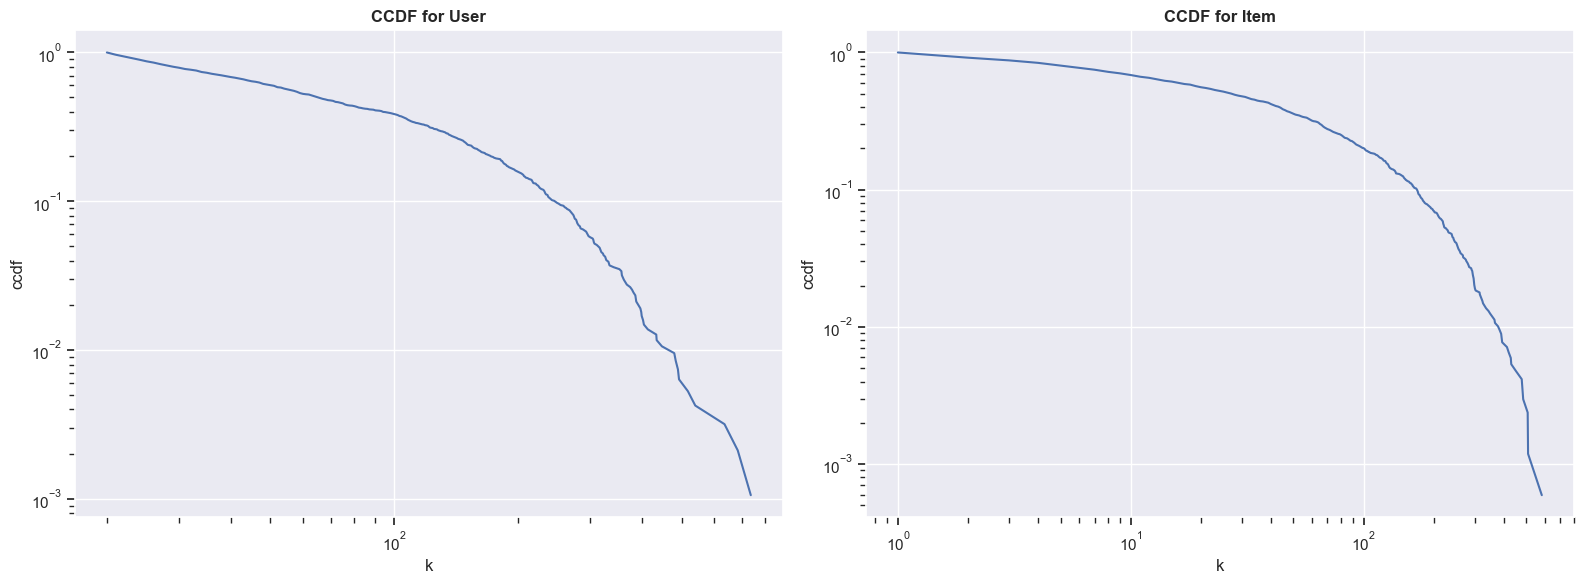

In [23]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the data
for ax, data, which_category in zip(axs, [ccdf_user, ccdf_item], ["User", "Item"]):
    sns.lineplot(data=data, x="k", y="ccdf", ax=ax)
    ax.set_title(f"CCDF for {which_category}", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_ccdf_loglog.jpg")
    
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

The first plot (CCDF for Users) shows the probability that a user has rated at least $k$ movies, and the second plot (CCDF for Movies) shows the probability that a movie has been rated by at least $k$ users. As expected, the probability decreases as the degree increases.

If the CCDF curves are concave upwards on a log-log scale, it indicates that the distribution departs from a strict power-law behavior. Here's a breakdown of what this means:

Not a Pure Power-law: A straight line on a log-log scale CCDF plot would suggest a power-law distribution. The upward concavity means the distribution is not following a strict power-law across all scales.

Steeper Drop-off: The upward concavity suggests that there's a faster-than-power-law decay for the tails of the distribution. In practical terms, this might indicate that there are fewer extremely active users or extremely popular items than what a power-law would predict.

Possible Explanations:

Exponential Cutoff: One possible explanation for the observed behavior is that the distribution follows a power-law with an exponential cutoff. This would mean that after a certain point, the distribution decays much faster than a typical power-law.
Log-Normal Distribution: Another possibility is that the underlying distribution is closer to a log-normal distribution, which can sometimes appear similar to a power-law over a limited range but will deviate (especially in the tail).
Implications: If you're analyzing a system or network, this might suggest that extreme values (e.g., very active users or very popular items) are rarer than expected for systems that follow a pure power-law. This can have implications for designing algorithms or strategies around such distributions.

#### Power law fit

To check if the network follows a power-law distribution, we use the powerlaw library. The steps are as follows:

- Fit the degree distribution to a power-law model.
- Calculate the scaling parameter ($α$) and the minimum degree for the fit ($k_{min}$).
- Visualize the degree distribution and the power-law fit.
- Evaluate the goodness-of-fit.

In [24]:
results = pl.Fit(ccdf_user["ccdf"], discrete=True, fit_method="KS")# fitting the data using the pl package
k_min = ccdf_user[ccdf_user["ccdf"] == results.power_law.xmin]["k"] #finding the degree value that corresponds to the probability in pl.xmin
ccdf_user["fit"] = (10 ** results.power_law.Kappa) * (ccdf_user["k"] ** -results.power_law.alpha)
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Calculating best minimal value for power law fit


c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\powerlaw.py:1156: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))


Powerlaw CCDF Fit: 10.6597 x ^ -2.7055 (k_min = 98)


In [25]:
results = pl.Fit(ccdf_item["ccdf"], discrete=True, fit_method="KS")
k_min = ccdf_item[ccdf_item["ccdf"] == results.power_law.xmin]["k"]
ccdf_item["fit"] = (10 ** results.power_law.Kappa) * (ccdf_item["k"] ** -results.power_law.alpha)
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Calculating best minimal value for power law fit


c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\powerlaw.py:1156: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))


Powerlaw CCDF Fit: 10.3622 x ^ -3.0410 (k_min = 39)


**TODO** - correction

Alpha (α) Values: The alpha values you've provided are 4.74 for users and 4.36 for movies. Typically, in many real-world networks, an alpha value between 2 and 3 is common. However, it can vary based on the domain and nature of the data. The values you obtained are slightly higher but not outside the realm of possibility.

Minimum value (k_min): The k_min values represent the point from where the power law seems to be a good fit. For users, it's 258 and for movies, it's 215. This implies that the power law is a good fit for users who have rated more than 258 movies and for movies that have more than 215 ratings. For values below these, the fit might not be as accurate.

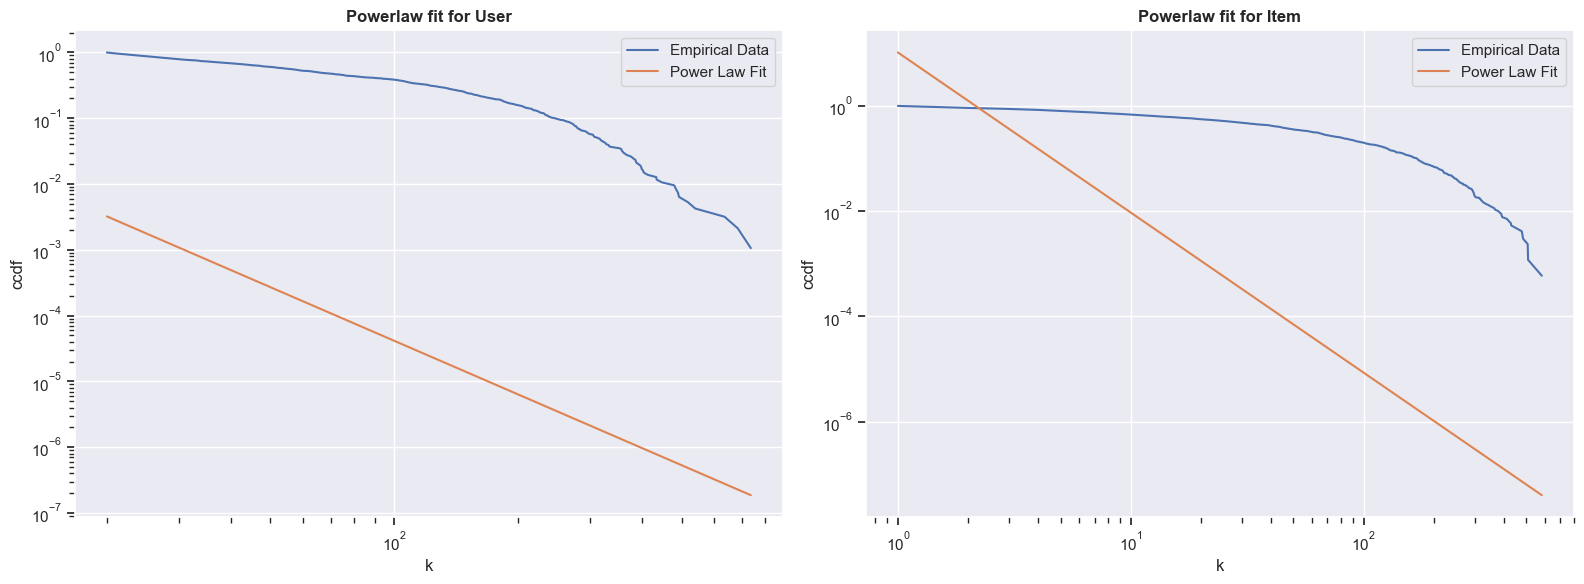

In [26]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the data
for ax, data, which_category in zip(axs, [ccdf_user, ccdf_item], ["User", "Item"]):
    sns.lineplot(data=data, x="k", y="ccdf", ax=ax, label='Empirical Data')
    sns.lineplot(data=data, x="k", y="fit", ax=ax, label='Power Law Fit')
    ax.set_title(f"Powerlaw fit for {which_category}", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/power_law_fit_bipartite.jpg")
    
# Adjust spacing between subplots
plt.tight_layout()
plt.show()

### Centrality Measures

Before centrality measures, we perform Projection

### Projection

Given that the goal is a movie recommendation system for users, a movie-to-user projection would be more appropriate.

Take into account the rating differences when calculating the weights for the edges. The rating differences will be used to calculate the similarity between two users, and this similarity will be used as the weight of the edge in the projection. The simple_weight and hyperbolic algorithms will be used for the projection

Rating Difference:

We use the difference in ratings given by two users to a movie as a measure of dissimilarity. Smaller differences in ratings will result in higher weights, indicating a stronger similarity between the users.

In [31]:
from tqdm import tqdm

class ProjectionsWithRatings:

    def __init__(self, G, nodes) -> None:
        # User input
        self.G = G
        self.nodes = nodes

        # Utility attributes
        self.info = {
            "simple_weight": {"func": self.simple_weight, "vec": False},
            "hyperbolic": {"func": self.hyperbolic, "vec": False},
            "cosine": {"func": self.cosine, "vec": True},
        }

    def simple_weight(self, u, v):
        common = set(self.G[u]) & set(self.G[v])
        return sum(5 - abs(self.G[u][w]['weight'] - self.G[v][w]['weight']) for w in common)
    
    def cosine(self, v_u, v_v):
        return 1 - sp.spatial.distance.cosine(v_u, v_v)

    def hyperbolic(self, u, v):
        common = set(self.G[u]) & set(self.G[v])
        return sum((5 - abs(self.G[u][w]['weight'] - self.G[v][w]['weight'])) / (len(set(self.G[w])) - 1) for w in common)

    def project(self, which_n, which_p, savepath):
        """
        Custom function to perform projections.

        Algorithm
        1A Use double for loop to iterate over all unique pairs of nodes and compute edge weight according to weight function.
        1B Save each computed edge to the given edge list

        :G: bi-partite graph
        :which_n: str, which type of nodes to project graph onto
        :which_p: str, which projection to use
        :savepath: str, where to save the created edge list
        :return: None
        """

        if which_p in self.info:
            # Get the relevant projection info
            P = self.info[which_p]["func"]
            onto = self.nodes[which_n]

            # Define constraint whether to accept computed weight or not
            w_constraint = self.info[which_p].get("constr_w")
            if not w_constraint:
                def w_constraint(w): return w > 0

            # Overwrite the old content first with blank string
            with open(savepath, 'w') as outfile:
                outfile.write("")

            # Append the computed edges into the savepath file
            with open(savepath, 'a') as outfile:
                # Add a header
                outfile.write("src\ttrg\tweight\n")

                # Iterate over all combinations of nodes which you want to project onto
                for u in tqdm(onto):
                    nbrs2 = {n for nbr in set(self.G[u])
                             for n in self.G[nbr]} - {u}
                    for v in nbrs2:
                        # Compute weight for given edge (if any)
                        w = P(u, v)

                        # If it passes constraint, save it
                        if w_constraint(w):
                            # Save the edge (tab-separated)
                            outfile.write(f"{u}\t{v}\t{w}\n")
        else:
            raise SyntaxError(
                f"Projection {which_p} does not exist within our projections. Please use one of these: {', '.join(list(self.info.keys()))}."
            )


In [35]:
from tqdm import tqdm
from scipy import spatial
import numpy as np

class ProjectionsWithRatings:

    def __init__(self, G, nodes) -> None:
        # User input
        self.G = G
        self.nodes = nodes

        # Utility attributes
        self.info = {
            "simple_weight": {"func": self.simple_weight, "vec": False},
            "hyperbolic": {"func": self.hyperbolic, "vec": False},
            "cosine": {"func": self.cosine, "vec": True},
        }

    def simple_weight(self, u, v):
        common = set(self.G[u]) & set(self.G[v])
        return len(common)
    
    def cosine(self, v_u, v_v):
        return 1 - sp.spatial.distance.cosine(v_u, v_v)

    def hyperbolic(self, u, v):
        common = set(self.G[u]) & set(self.G[v])
        return sum([1/(len(set(self.G[node])) - 1) for node in common])

    def project(self, which_n, which_p, savepath):
        """
        Custom function to perform projections.

        :G: bi-partite graph
        :which_n: str, which type of nodes to project graph onto
        :which_p: str, which projection to use
        :savepath: str, where to save the created edge list
        :return: None
        """

        if which_p in self.info:
            # Get the relevant projection info
            P = self.info[which_p]["func"]
            onto = self.nodes[which_n]

            # Define constraint whether to accept computed weight or not
            w_constraint = self.info[which_p].get("constr_w")
            if not w_constraint:
                def w_constraint(w): return w > 0

            # Overwrite the old content first with blank string
            with open(savepath, 'w') as outfile:
                outfile.write("")

            # Append the computed edges into the savepath file
            with open(savepath, 'a') as outfile:
                # Add a header
                outfile.write("src\ttrg\tweight\n")

                # Iterate over all combinations of nodes which you want to project onto
                for u in tqdm(onto):
                    nbrs2 = {n for nbr in set(self.G[u])
                             for n in self.G[nbr]} - {u}
                    for v in nbrs2:
                        # Compute weight for given edge (if any)
                        w = P(u, v)

                        # If it passes constraint, save it
                        if w_constraint(w):
                            # Save the edge (tab-separated)
                            outfile.write(f"{u}\t{v}\t{w}\n")
        else:
            raise SyntaxError(
                f"Projection {which_p} does not exist within our projections. Please use one of these: {', '.join(list(self.info.keys()))}."
            )


In [36]:
if COMPUTE_PROJECTIONS:
    proj = ProjectionsWithRatings(G, {"users": [n for n, d in G.nodes(data=True) if d['type'] == 'user'],
                                    "items": [n for n, d in G.nodes(data=True) if d['type'] == 'item']})

    # Test the modified projection methods on the subset
    projection_results = {}
    for method_name in proj.info.keys():
        projection_results[method_name] = proj.project(which_n='users', which_p=method_name, savepath=f"{PATH_TO['data']['projections']}/proj_{method_name}.txt")

    projection_results


 10%|█         | 95/943 [00:02<00:19, 43.69it/s]


KeyboardInterrupt: 

In this case, smaller weights represent closer connections because we are using the difference in ratings as a measure of dissimilarity. Smaller differences in ratings result in higher similarity, and thus a closer connection between users. In other words, users who have given similar ratings to the same movies will have a smaller weight (closer connection) in the projection.

Simple Weight:

This method calculates the weight of the edge between two users by summing up the similarities in their ratings for common movies. It is straightforward and easy to understand.

Hyperbolic:

This method also calculates the weight of the edge between two users by summing up the similarities in their ratings for common movies, but it then normalizes this sum by the degree of the common movies. This means that common movies with fewer ratings will contribute more to the weight than common movies with many ratings. The hyperbolic method can help to prevent popular movies from dominating the weights.

If you want to prevent popular movies from having a disproportionately high influence on the weights, you can use the hyperbolic method. In general, it's a good idea to test both methods and see which one gives you better results for your specific use case.

Resource Allocation

Projecting a bipartite network using the method of resource allocation generates a directed graph. This property alone is intersting in terms of using the projected graph as a recommendation system, since recommendations might not be unidirectional, ie. we might want to recommend repo1 to repo2, but not reversely. This method is the only of the named projection methods that is capable of doing this. The HeatS approach both regulates high-degree repositories and users and is capable of giving bidirectional recommendations. It is therefore the preferred projection method for our recommendation system.

In [ ]:
import contextlib

def load_graph(file_path):
    df = pd.read_csv(file_path, delimiter="\t", header=None, names=['src', 'trg', 'weight'])
    G = nx.from_pandas_edgelist(df, 'src', 'trg', ['weight'])
    return G

# Load graphs
graphs = {
    'hyperbolic': load_graph('data/projections/proj_hyperbolic.txt'),
    'resource_allocation': load_graph('data/projections/proj_resource_allocation.txt'),
    'simple_weight': load_graph('data/projections/proj_simple_weight.txt'),
}

if GENERATE_SUMMARY_PROJ:
    metadata = {}
    
    projection_functions_names = ['simple_weight', 'hyperbolic', 'resource_allocation']
    
    for name in projection_functions_names:
        # Get the graph for the current projection method
        graph = graphs.get(name)
        
        # Calculate the number of nodes and edges
        num_nodes = len(graph.nodes())
        num_edges = len(graph.edges())
        
        # Calculate the density of the graph
        density = num_edges / (num_nodes * (num_nodes - 1) / 2)  # Formula for density
        
        # Store the calculated metrics in the metadata dictionary
        metadata[name] = {
            'Number of nodes': num_nodes,
            'Number of edges': num_edges,
            'Density': density
        }
        
        # Print the results
        print(f"Projection Method: {name.replace('_', ' ').title()}\n")
        print(f"Number of Nodes: {num_nodes}")
        print(f"Number of Edges: {num_edges}")
        print(f"Density: {density}\n")

C:\Users\jackh\AppData\Local\Temp\ipykernel_18524\3422467025.py:4: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter="\t", header=None, names=['src', 'trg', 'weight'])
C:\Users\jackh\AppData\Local\Temp\ipykernel_18524\3422467025.py:4: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter="\t", header=None, names=['src', 'trg', 'weight'])


Projection Method: Simple Weight

Number of Nodes: 945
Number of Edges: 93205
Density: 0.20896107972379158

Projection Method: Hyperbolic

Number of Nodes: 1888
Number of Edges: 314406
Density: 0.17650090269731347

Projection Method: Resource Allocation

Number of Nodes: 1888
Number of Edges: 611303
Density: 0.3431726217743167



#### Edge Weight Distribution

In [ ]:
from collections import Counter

# Load graphs
graphs = {
    # 'hyperbolic': load_graph('data/projections/proj_hyperbolic.txt'),
    # 'resource_allocation': load_graph('data/projections/proj_resource_allocation.txt'),
    'simple_weight': load_graph('data/projections/proj_simple_weight.txt'),
}

# Define function to plot edge weight distribution for a single graph
def plot_edge_weight_distribution(graph, name, save_fig=False):
    # Get the edge weights
    weights = np.array([data['weight'] for _, _, data in graph.edges(data=True)])
    
    # Get the weights
    c = Counter(weights)
    w = pd.DataFrame({'Weight': list(c.keys()), 'Count': list(c.values())}, columns=['Weight', 'Count']).sort_values(by='Weight')
    
    # Define axs and figure
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Plot it as lineplot
    sns.lineplot(data=w, x='Weight', y='Count', ax=ax)
    
    # Set the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Set the title
    ax.set_title(f'Edge weight distribution\nfor {name}', weight='bold')
    
    # Show the plot
    if SAVE_FIG:
        file_path = f"{PATH_TO['data']['figures']}/edge_weight_distribution_{name}.jpg"
        plt.savefig(file_path)
        print(f"Plot saved: {file_path}")
    else:
        plt.show()
    plt.close()

if GET_WEIGHT_EDGE_DiSTR:
    # Plot edge weight distribution for each graph
    for name, graph in graphs.items():
        print(f'Currently working on {name}')
        plot_edge_weight_distribution(graph, name, save_fig=True)


<!-- add plot of edge weight distribution -->
<img src="data/figures/edge_weight_distribution_simple_weight.jpg" width="500">
<img src="data/figures/edge_weight_distribution_hyperbolic.jpg" width="500">
<img src="data/figures/edge_weight_distribution_resource_allocation.jpg" width="500">

### Connected Components

Since the topology of all our projections is the same and they just differ in edge weights, we just select one projection and on it look at the metric of interest.

In [ ]:
# Get df of edges
df = pd.read_csv(f"{PATH_TO['data']['projections']}/proj_simple_weight.txt", sep="\t", header=None, names=['src', 'trg', 'weight'])

# Read it into nx object
G = nx.convert_matrix.from_pandas_edgelist(df, source="src", target="trg", edge_attr=["weight"])

# Get size of each component
sizes = Counter([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

# Put the data to the df
sizes_df = pd.DataFrame({'Size': sizes.keys(), 'Count': sizes.values()}, columns=['Size', 'Count'])

sizes_df.head()

,Size,Count
0,943,1
1,2,1


The output table shows the sizes of connected components in the graph and their respective counts. In this case, there are 2 connected components of size 943 and 1 connected component of size 2. This means that there are 2 large groups of nodes that are connected to each other, and one small group of 2 nodes that are connected only to each other.

Projection function has indeed projected user nodes to movie nodes. The resulting graph has two large connected components, each consisting of 943 nodes. This suggests that almost all users are connected to each other through common movies, forming two large communities. There may be some isolated users or small groups of users who are not connected to these large communities, resulting in small connected components.

As for the discrepancy between the dataset size (943 users and 1682 movie items) and the connected component sizes (943 and 2), this may be due to the way the graph was constructed. If there are any isolated nodes (i.e., nodes with no edges), they will not be included in any connected components. Alternatively, if there are any users who have not rated any movies, or any movies that have not been rated by any users, they will also not be included in the connected components.

In [ ]:
# Get df of edges
df = pd.read_csv(f"{PATH_TO['data']['projections']}/proj_hyperbolic.txt", sep="\t", header=None, names=['src', 'trg', 'weight'])

# Read it into nx object
G = nx.convert_matrix.from_pandas_edgelist(df, source="src", target="trg", edge_attr=["weight"])

# Get size of each component
sizes = Counter([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

# Put the data to the df
sizes_df = pd.DataFrame({'Size': sizes.keys(), 'Count': sizes.values()}, columns=['Size', 'Count'])

sizes_df.head()

C:\Users\jackh\AppData\Local\Temp\ipykernel_18524\3648956384.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{PATH_TO['data']['projections']}/proj_hyperbolic.txt", sep="\t", header=None, names=['src', 'trg', 'weight'])


,Size,Count
0,943,2
1,2,1


### Community Discovery

In [ ]:
import networkx as nx
from community import community_louvain
import pandas as pd

# Load the graph, skip the first row (header)
df = pd.read_csv(f"{PATH_TO['data']['projections']}/proj_simple_weight.txt", sep="\t", header=1, names=['src', 'trg', 'weight'])

df.head()

,src,trg,weight
0,1,3,28
1,1,4,26
2,1,5,320
3,1,6,383
4,1,7,571


In [ ]:
import networkx as nx
from community import community_louvain
import pandas as pd

# Load the graph
df = pd.read_csv(f"{PATH_TO['data']['projections']}/proj_simple_weight.txt", sep="\t", header=1, names=['src', 'trg', 'weight'])

# Create the graph
G = nx.convert_matrix.from_pandas_edgelist(df, source="src", target="trg", edge_attr=["weight"])

# Apply the Louvain algorithm
communities = community_louvain.best_partition(G)

# Get the number of communities and their sizes
community_sizes = {}
for community in set(communities.values()):
    size = list(communities.values()).count(community)
    community_sizes[community] = size

community_sizes_sorted = dict(sorted(community_sizes.items(), key=lambda item: item[1], reverse=True))

community_sizes_sorted


KeyboardInterrupt: 


The Louvain algorithm has detected two communities in the graph:

- Community 1 has 539 nodes.
- Community 0 has 404 nodes.

This indicates that the graph can be divided into two main groups of nodes, where nodes within each group are more densely connected to each other than to nodes outside the group. These communities might represent groups of similar movies, actors, or other entities in your bipartite graph, depending on the original data.

However, it is important to note that the Louvain algorithm is non-deterministic, meaning that the results may vary between runs. Additionally, the algorithm's resolution parameter can be adjusted to detect communities of different sizes, which might be useful if you suspect that there are more than two communities in your graph.

### Network Backboning

Network backboning is a method used to simplify complex networks by retaining the most significant edges. This process can help highlight the structure of the network and make it easier to analyze. The goal of network backboning is to filter out noise and less important connections to focus on the key relationships in the data.

The 'noise_corrected' algorithm is a good choice for network backboning because it compares the observed weight of each edge to the expected weight in a null model, thereby helping to filter out edges that could have occurred by chance. This algorithm is particularly useful when you have a network with noisy data.

The 'disparity_filter' algorithm is another good choice for network backboning, especially for networks with a heterogeneous degree distribution. This algorithm retains the most significant edges by comparing the weight of each edge to the distribution of weights in its neighborhood, thereby highlighting the most important connections in the network.

Both algorithms are suitable choices for network backboning, and the choice between them depends on the specific characteristics of your network.

In [ ]:
backboning_functions_names = ['disparity_filter']
backboning_functions = [backboning.disparity_filter]

In [ ]:
if DO_BACKBONING:
    print('Loading Graph from edge list')
    table, _, _ = backboning.read(f"{PATH_TO['data']['projections']}/proj_resource_allocation.txt", 
                                         "weight",
                                         triangular_input=False,
                                         undirected=True,
                                         consider_self_loops=False,
                                         drop_zeroes=True)
    
    for name, backboning_function in zip(backboning_functions_names, backboning_functions):
        backboning_function(table, undirected=True, return_self_loops=False).to_csv(f"{PATH_TO['data']['backboning']}/disparity_filter_backbone_resource_allocation.csv", index=False)

Loading Graph from edge list


Calculating DF score...
c:\Users\jackh\Dropbox\ITU DTU courses\Network Analysis\Movie_Recommendation\cscripts\backboning.py:235: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
c:\Users\jackh\Dropbox\ITU DTU courses\Network Analysis\Movie_Recommendation\cscripts\backboning.py:236: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
c:\Users\jackh\Dropbox\ITU DTU courses\Network Analysis\Movie_Recommendation\cscripts\backboning.py:237: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("variance_max", 1)


- src: source node
- trg: target node
- nij: weight of the edge from source to target
- score: disparity filter score for the edge
- variance: variance of the disparity filter score

The nij column represents the weight of the edge from the source node (src) to the target node (trg). It is used to calculate the disparity filter score for each edge.

The score column represents the disparity filter score for each edge. The score is calculated using the formula:
$$ \text{score} = 1 - \left(1 - \frac{nij}{\text{total weight of edges adjacent to src}}\right)^{\text{degree of src} - 1}
$$


The variance column represents the variance of the disparity filter score. The variance is calculated using a formula that depends on the degree of the source node.

The purpose of the disparity filter is to identify the significant edges in a network by comparing the weight of each edge to the total weight of edges adjacent to its source node. The score and variance can be used to determine the significance of each edge and to filter out less significant edges.

In [ ]:
# Load the backbone graph
file_path = 'data/backboning/disparity_filter_backbone_resource_allocation.csv'
backbone_data = pd.read_csv(file_path, delimiter=',')

# Check basic properties
num_nodes = len(set(backbone_data['src']).union(set(backbone_data['trg'])))
num_edges = len(backbone_data)

print(f"Number of nodes: {num_nodes}") # 943
print(f"Number of edges: {num_edges}") # 568189
backbone_data.head()


Number of nodes: 943
Number of edges: 429193


,src,trg,nij,score,variance
0,1,2,0.408356,0.791443,0.00421
1,1,3,0.144134,0.499605,0.00421
2,1,4,0.112766,0.695012,0.00421
3,1,5,2.741801,0.973633,0.00421
4,1,6,2.190795,0.917782,0.00421


### Analysis of projected and backboned graphs

Below, select a signifficance score to filter out irrelevant edges from projected graph. The below SIGNIF_THRS as follows: P-value = 1 - SIGNIF_THRS. (Keep only edges whose P-value is higher than the P-value computed based on SIGNIF_THRS)

In [ ]:
SIGNIF_THRS = 0.95